# Bayesian parameter estimation for an irregularly, noisily, and partially sampled non-linear SDE (Lorenz 63 w/ diffusion) via auto-differentiable non-linear filtering and HMC

We show how to use the [blackjax](https://github.com/blackjax-devs/blackjax) libray to compute the parameter posterior $p(\theta|y(1:T))$
for non-linear model. We use the Extended Kalman filter to compute an approximate marginal likelihood.

Specifically, we observe only the first component of the Lorenz 63 system and try to recover the parameter $\sigma$ in the original equations.
We assume all other features of the system are known, but demonstrate how to perform this inference under irregular sampling and partial, noisy observations.

First, we demonstrate that different filters provide different approximations of this likelihood surface (in our simulations, the EKF and UKF are faster more accurately resolve the MLE than the EnKF).

Then, we run stochastic gradient descent on the (EKF-approximated) log likelihood of the data given parameter $\sigma$.
We use this SGD-based approximation of the MLE/MAP to initialize MCMC (Hamiltonian Monte Carlo).
Note that MCMC also uses the EKF-approximation of the log likelihood, and thus provides samples from an approximate posterior.
We plot these resulting samples; we observe a tight posterior containing the true value, whose center is slightly biased away from the true value. This bias corresponds to the one we see for EKF in our earlier experiments in this notebook.



## Setup

In [1]:
import sys
%matplotlib inline
sys.path.append("../../..")
sys.path.append("../..")

import dynamax

from jax import numpy as jnp
from jax import vmap
import jax.random as jr
from matplotlib import pyplot as plt


# use custom src codebase
from utils.plotting_utils import *

# from utils.utils import monotonically_increasing
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm.models import *


/opt/homebrew/anaconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count

from dynamax.parameters import log_det_jac_constrain

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

## Generate synthetic training data

In [3]:
# Simulate synthetic data from true model
state_dim = 3
emission_dim = 1
num_sequences = 1
T = 300
num_timesteps = 30000
t_emissions = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))
# drop duplicates
t_emissions = jnp.unique(t_emissions)[:,None]
num_timesteps = len(t_emissions)
keys = map(jr.PRNGKey, count())

## GOAL is to only learn parameters of the drift function and assume all other parameters are known.
dynamics_drift = {
    "params": LearnableLorenz63(sigma=10.0, rho=28.0, beta=2.666),
    "props": LearnableLorenz63(sigma=ParameterProperties(),
                               rho=ParameterProperties(),
                               beta=ParameterProperties()) 
}

dynamics_diffusion_coefficient = {
    "params": LearnableMatrix(params=jnp.eye(state_dim)),
    "props": LearnableMatrix(params=ParameterProperties(trainable=False))
}

dynamics_diffusion_cov = {
    "params": LearnableMatrix(params=jnp.eye(state_dim)),
    "props": LearnableMatrix(params=ParameterProperties(constrainer=RealToPSDBijector(), trainable=False))
}

emission_function = {
    "params": LearnableLinear(weights=jnp.eye(emission_dim, state_dim), bias=jnp.zeros(emission_dim)),
    "props": LearnableLinear(weights=ParameterProperties(trainable=False), bias=ParameterProperties(trainable=False))
}

emission_cov = {
    "params": LearnableMatrix(params=jnp.eye(emission_dim)),
    "props": LearnableMatrix(params=ParameterProperties(constrainer=RealToPSDBijector(), trainable=False))
}

initial_mean = {"params": jnp.zeros(state_dim),
                "props": ParameterProperties(trainable=False)}

initial_cov = {"params": 100*jnp.eye(state_dim),
                "props": ParameterProperties(trainable=False, constrainer=RealToPSDBijector())}


true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
true_params, _ = true_model.initialize(
    next(keys),
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dynamics_drift=dynamics_drift,
    dynamics_diffusion_coefficient=dynamics_diffusion_coefficient,
    dynamics_diffusion_cov=dynamics_diffusion_cov,
    emission_function=emission_function,
    emission_cov=emission_cov,
)

# sample true states and emissions. Using transition_type="path" to solve SDE.
# true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions)
# true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions, transition_type="path")
true_states, emissions = true_model.sample_batch(
    true_params, next(keys), num_sequences, num_timesteps, t_emissions, transition_type="path"
)

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.


In [4]:
def plot_results(emissions, smoothed_emissions, smoothed_emissions_std):
    # all arrays are (T, E) dimensional, T=ntime, E=emission_dim
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emission_dim):
        plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(smoothed_emissions[:, i] + spc * i,
                    label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            jnp.arange(num_timesteps),
            spc * i + smoothed_emissions[:, i] - 2 * smoothed_emissions_std[:, i],
            spc * i + smoothed_emissions[:, i] + 2 * smoothed_emissions_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, num_timesteps - 1)
    plt.ylabel("true and predicted emissions")
    plt.legend()

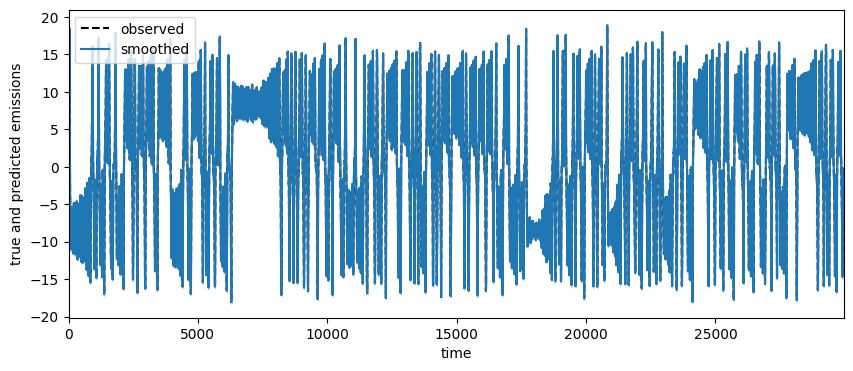

In [5]:
# plot results
plot_results(true_states[0], true_states[0], 0.1 * jnp.ones_like(true_states[0]))  # fake posterior variance

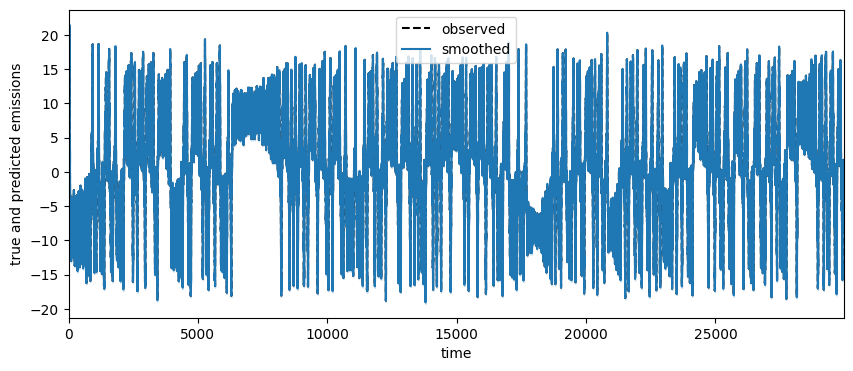

In [6]:
# plot results
plot_results(emissions[0], emissions[0], 0.1 * jnp.ones_like(emissions[0]))  # fake posterior variance

## Compute marginal log prob of the data under different parameter values and under different filter-based approximations (EnKF, EKF, UKF)

In [7]:
from continuous_discrete_nonlinear_gaussian_ssm import *
from dynamax.utils.utils import ensure_array_has_batch_dim, pytree_stack
from functools import partial


def update_params_sigma(params, sigma):
    return params._replace(dynamics=params.dynamics._replace(drift=params.dynamics.drift._replace(sigma=sigma)))

# @jit
def compute_log_likelihood(sigma, params, filter_hyperparams, emissions, t_emissions, inputs):
    params_mod = update_params_sigma(params, sigma)
    log_prob = true_model.marginal_log_prob(
        params_mod,
        filter_hyperparams=filter_hyperparams,
        emissions=emissions,
        t_emissions=t_emissions,
        inputs=inputs,
    )
    return log_prob

# make a list of sigmas from 0.1 to 20
sigmas = jnp.linspace(5, 15, 200)

# make sure the true sigma is also in the list
sigmas = jnp.concatenate([sigmas, jnp.array([true_params.dynamics.drift.sigma])])
# sort the list
sigmas = jnp.sort(sigmas)

## Do EKF
compute_log_likelihood_partial = partial(
    compute_log_likelihood,
    params=true_params,
    filter_hyperparams= EKFHyperParams(),
    emissions=emissions[0],
    t_emissions=t_emissions,
    inputs=None  # Assuming inputs are prepared similar to emissions and t_emissions
)

# Vectorize computation over sigmas
lls_ekf = vmap(compute_log_likelihood_partial)(sigmas)


### Do EnKF with 30 particles
compute_log_likelihood_partial = partial(
    compute_log_likelihood,
    params=true_params,
    filter_hyperparams=EnKFHyperParams(N_particles=30),
    emissions=emissions[0],
    t_emissions=t_emissions,
    inputs=None,  # Assuming inputs are prepared similar to emissions and t_emissions
)

# Vectorize computation over sigmas
lls_enkf30 = vmap(compute_log_likelihood_partial)(sigmas)

### Do EnKF with 100 particles
compute_log_likelihood_partial = partial(
    compute_log_likelihood,
    params=true_params,
    filter_hyperparams=EnKFHyperParams(N_particles=100),
    emissions=emissions[0],
    t_emissions=t_emissions,
    inputs=None,  # Assuming inputs are prepared similar to emissions and t_emissions
)

# Vectorize computation over sigmas
lls_enkf100 = vmap(compute_log_likelihood_partial)(sigmas)

### Do UKF
compute_log_likelihood_partial = partial(
    compute_log_likelihood,
    params=true_params,
    filter_hyperparams=UKFHyperParams(),
    emissions=emissions[0],
    t_emissions=t_emissions,
    inputs=None,  # Assuming inputs are prepared similar to emissions and t_emissions
)

# Vectorize computation over sigmas
lls_ukf = vmap(compute_log_likelihood_partial)(sigmas)

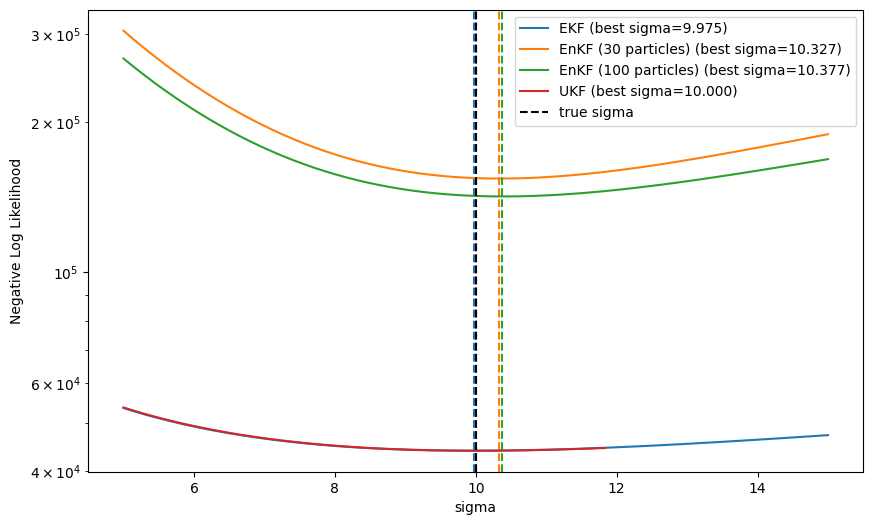

In [8]:
# Plot the log likelihoods for different sigmas and filters
plt.figure(figsize=(10, 6))

best_sigma = sigmas[jnp.nanargmin(-lls_ekf)]
plt.plot(sigmas, -lls_ekf, color="C0", label=f"EKF (best sigma={best_sigma:.3f})")
plt.axvline(x=best_sigma, color="C0", linestyle="--")

best_sigma = sigmas[jnp.nanargmin(-lls_enkf30)]
plt.plot(sigmas, -lls_enkf30, color="C1", label=f"EnKF (30 particles) (best sigma={best_sigma:.3f})")
plt.axvline(x=best_sigma, color="C1", linestyle="--")

best_sigma = sigmas[jnp.nanargmin(-lls_enkf100)]
plt.plot(sigmas, -lls_enkf100, color="C2", label=f"EnKF (100 particles) (best sigma={best_sigma:.3f})")
plt.axvline(x=best_sigma, color="C2", linestyle="--")

best_sigma = sigmas[jnp.nanargmin(-lls_ukf)]
plt.plot(sigmas, -lls_ukf, color="C3", label=f"UKF (best sigma={best_sigma:.3f})")
plt.axvline(x=best_sigma, color="C3", linestyle="--")

plt.axvline(x=true_params.dynamics.drift.sigma, color="black", linestyle="--", label="true sigma")
plt.xlabel("sigma")
plt.ylabel("Negative Log Likelihood")
plt.legend()
plt.yscale("log")
plt.show()

## Baseline method: use SGD to compute MLE

In [9]:
# Initilize parameters by fitting SGD algorithm
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter
from continuous_discrete_nonlinear_gaussian_ssm import *
from continuous_discrete_nonlinear_gaussian_ssm.models import *
num_epochs = 50

# filter_hyperparams = EnKFHyperParams(N_particles=30)
filter_hyperparams = EKFHyperParams()

test_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)

initial_params, param_props = test_model.initialize(
    next(keys),
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dynamics_drift={
        "params": LearnableLorenz63(sigma=10.5, rho=28.0, beta=2.666),
        "props": LearnableLorenz63(
            sigma=ParameterProperties(trainable=True),
            rho=ParameterProperties(trainable=False),
            beta=ParameterProperties(trainable=False),
        ),
    },
    dynamics_diffusion_coefficient=dynamics_diffusion_coefficient,
    dynamics_diffusion_cov=dynamics_diffusion_cov,
    emission_function=emission_function,
    emission_cov=emission_cov,
)

import optax

# fitted_params, marginal_lls = test_model.fit_em(initial_params, param_props, emissions, num_iters=num_iters)
fitted_params, marginal_lls = test_model.fit_sgd(
    initial_params,
    param_props,
    emissions,
    filter_hyperparams=filter_hyperparams,
    t_emissions=t_emissions,
    num_epochs=num_epochs,
    optimizer=optax.adam(1e-1)
)

# print final parameter sigma
print(fitted_params.dynamics.drift.sigma)

9.99135


In [10]:
# check which param_props are trainable
print(param_props.initial.mean.trainable)
print(param_props.initial.cov.trainable)
print(param_props.dynamics.drift.sigma.trainable)
print(param_props.dynamics.drift.rho.trainable)
print(param_props.dynamics.drift.beta.trainable)
print(param_props.dynamics.diffusion_coefficient.params.trainable)
print(param_props.dynamics.diffusion_cov.params.trainable)
print(param_props.emissions.emission_function.weights.trainable)
print(param_props.emissions.emission_function.bias.trainable)
print(param_props.emissions.emission_cov.params.trainable)

False
False
True
False
False
False
False
False
False
False


In [11]:
# Extract fitted params
fitted_C = fitted_params.emissions.emission_function.weights
fitted_d = fitted_params.emissions.emission_function.bias
fitted_R = fitted_params.emissions.emission_cov.params

# Compute predicted emissions with vmap
filtered_posterior = vmap(
    lambda x: cdnlgssm_filter(fitted_params, emissions=x, hyperparams=filter_hyperparams, t_emissions=t_emissions)
)(emissions)

# filtered_posterior = cdnlgssm_filter(
#     fitted_params, emissions=emissions, hyperparams=filter_hyperparams, t_emissions=t_emissions
# )
filtered_emissions_mean = filtered_posterior.filtered_means @ fitted_C.T + fitted_d

# compute cov and std from this
filtered_emissions_cov = filtered_posterior.filtered_covariances @ fitted_C.T + fitted_R  # (10, 3000, 3, 3)

# use vmap to compute std for each sequence
filtered_emissions_std = vmap(lambda x: jnp.sqrt(jnp.array([x[:, i, i] for i in range(emission_dim)]).T))(filtered_emissions_cov)
# filtered_emissions_std # (10, 3000, 3)
# filtered_emissions_std = jnp.sqrt(jnp.array([filtered_emissions_cov[:, i, i] for i in range(emission_dim)]).T)  # (3, 10, 3)
# Need to compute std for each sequence


# filtered_emissions_cov = fitted_C @ filtered_posterior.filtered_covariances @ fitted_C.T + fitted_R
# filtered_emissions_std = jnp.sqrt(jnp.array([filtered_emissions_cov[:, i, i] for i in range(emission_dim)])).T  # (T,E)

Text(0.5, 1.0, 'Marginal log likelihood over iterations')

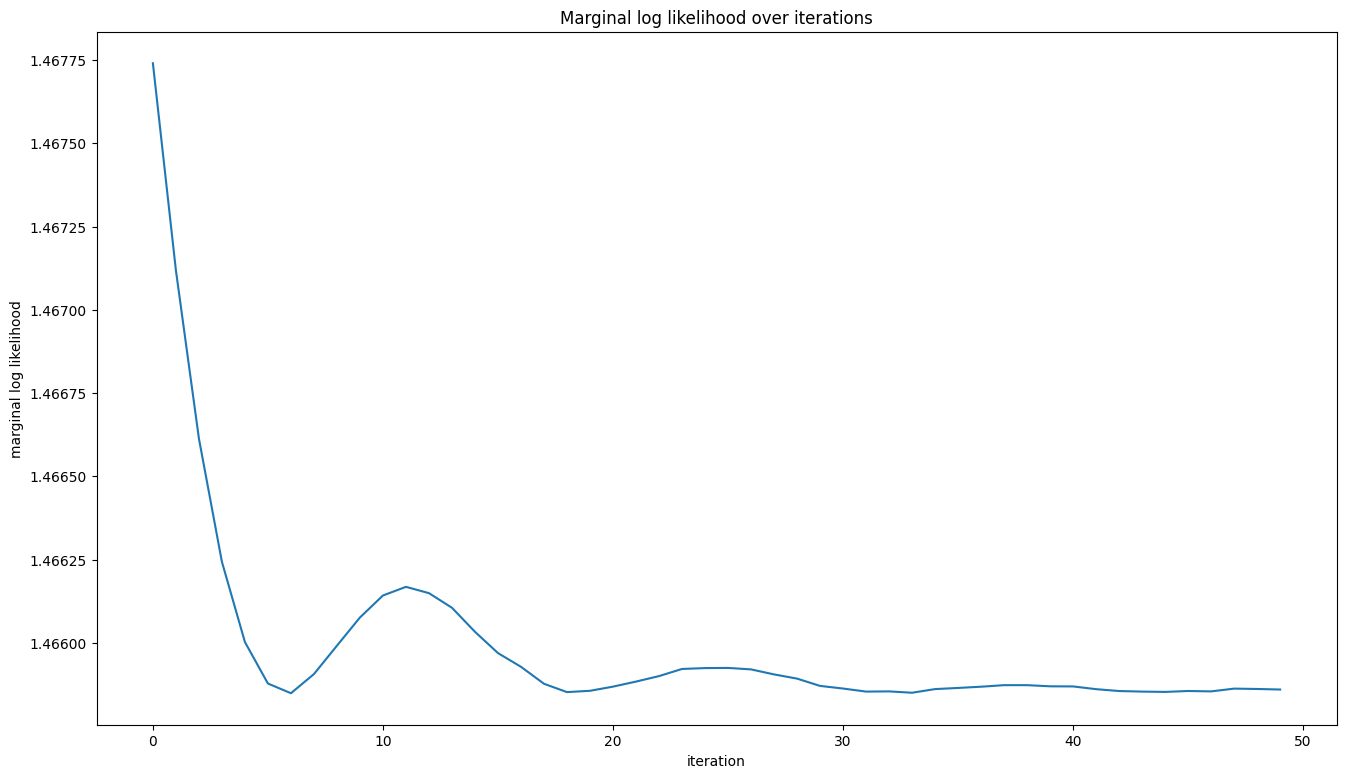

In [12]:
# plot the marginal lls over iterations for SGD
plt.plot(marginal_lls)
plt.xlabel("iteration")
plt.ylabel("marginal log likelihood")
# plt.autoscale(enable=True, axis="x", tight=True)
plt.title("Marginal log likelihood over iterations")

[(1, 29952, 1), (1, 29952, 1), (1, 29952, 1)]


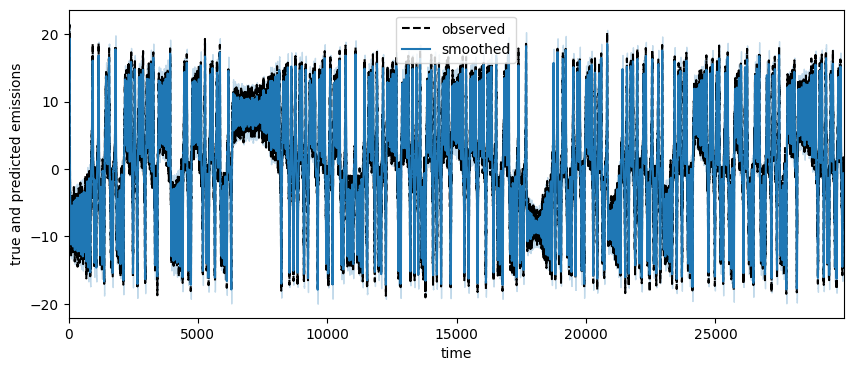

In [13]:
print([emissions.shape, filtered_emissions_mean.shape, filtered_emissions_std.shape])
plot_results(emissions[0], filtered_emissions_mean[0], filtered_emissions_std[0])

Text(0.5, 0, 'time')

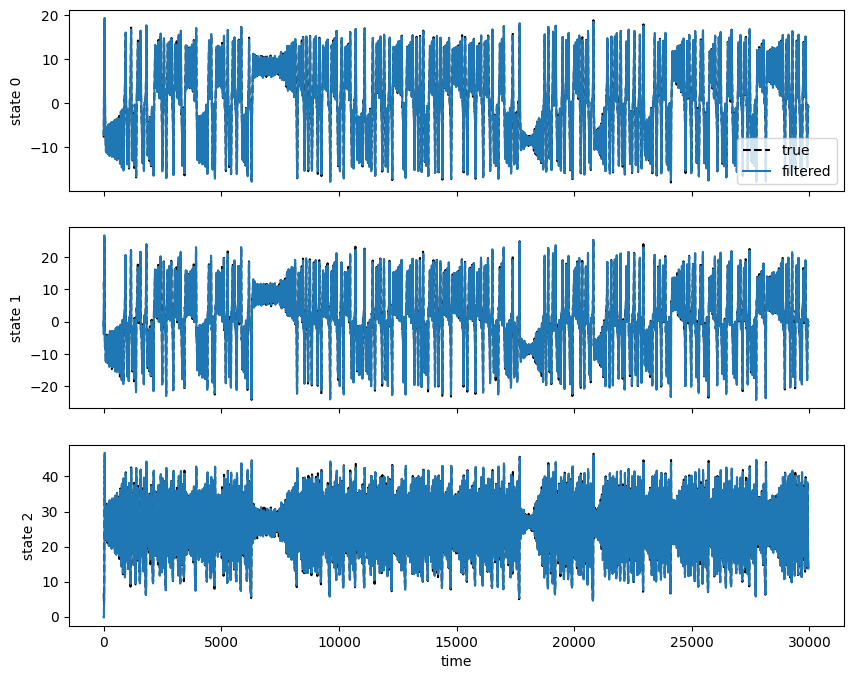

In [14]:
# now plot the true states and the filtered states, each in its own subplot
fig, axs = plt.subplots(state_dim, 1, figsize=(10, 8), sharex=True)
for i in range(state_dim):
    axs[i].plot(true_states[0, :, i], "--k", label="true" if i == 0 else None)
    axs[i].plot(filtered_posterior.filtered_means[0, :, i], label="filtered" if i == 0 else None)
    axs[i].set_ylabel(f"state {i}")
    if i == 0:
        axs[i].legend()
axs[-1].set_xlabel("time")

## Implement HMC wrapper

In [15]:
@jit
def filter_emission(params):
    C = params.emissions.emission_function.weights
    d = params.emissions.emission_function.bias
    filtered_posterior = cdnlgssm_filter(
        params, emissions=emissions[0], hyperparams=filter_hyperparams, t_emissions=t_emissions
    )

    return filtered_posterior.filtered_means @ C.T + d    

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def plot_param_distributions(samples, true, sgd, name='', burn_in_frac=0.5):
    """
    Plots N_params horizontal box plots for the given N_params x N_samples matrix.

    Parameters:
    - samples: N_params x N_samples matrix of parameter samples.
    - true: N_params array of true parameter values.
    - sgd: N_params array of SGD estimates.
    - name: Name of the parameter set.
    - burn_in_frac: Fraction of samples to discard as burn-in.

    Returns:
    - A matplotlib figure with N_params horizontal box plots.
    """
    N_params = samples.shape[0]
    fig, ax = plt.subplots(figsize=(10, N_params * 2))  # Adjust figure size based on number of parameters

    # apply burn-in
    burn_in = int(burn_in_frac * samples.shape[1])
    samples = samples[:, burn_in:]
    
    # Create box plots
    ax.boxplot(samples, vert=False, patch_artist=True)

    # Set the y-axis labels to show parameter indices
    ax.set_yticks(range(1, N_params + 1))
    ax.set_yticklabels(["Parameter {}".format(i + 1) for i in range(N_params)])

    # Plot ground truth and estimates
    ax.scatter(sgd, range(1, N_params + 1), color="magenta", marker="o", s=100, label="SGD Estimate", zorder=3)
    ax.scatter(true, range(1, N_params + 1), color="red", marker="x", s=100, label="Ground Truth", zorder=4)

    plt.xlabel("Value")
    plt.ylabel("Parameters")
    plt.title("{} Parameter Distributions".format(name))
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_all(param_samples, burn_in_frac=0.5):
    """
    Plots the posterior distributions of all parameters.
    Burn-in is removed from the samples.
    """
    plot_param_distributions(
        param_samples.initial.mean.T, true_params.initial.mean, fitted_params.initial.mean, name="Initial mean",
        burn_in_frac=burn_in_frac
    )
    plot_param_distributions(
        param_samples.initial.cov.reshape(param_samples.initial.cov.shape[0], -1).T,
        true_params.initial.cov.flatten(),
        fitted_params.initial.cov.flatten(),
        name="Initial cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.sigma.reshape(param_samples.dynamics.drift.sigma.shape[0], -1).T,
        true_params.dynamics.drift.sigma,
        fitted_params.dynamics.drift.sigma,
        name="Dynamics drift sigma",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.rho.reshape(param_samples.dynamics.drift.rho.shape[0], -1).T,
        true_params.dynamics.drift.rho,
        fitted_params.dynamics.drift.rho,
        name="Dynamics drift rho",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.beta.reshape(param_samples.dynamics.drift.beta.shape[0], -1).T,
        true_params.dynamics.drift.beta,
        fitted_params.dynamics.drift.beta,
        name="Dynamics drift beta",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_cov.params.reshape(param_samples.dynamics.diffusion_cov.params.shape[0], -1).T,
        true_params.dynamics.diffusion_cov.params.flatten(),
        fitted_params.dynamics.diffusion_cov.params.flatten(),
        name="Dynamics diffusion cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_coefficient.params.reshape(
            param_samples.dynamics.diffusion_coefficient.params.shape[0], -1
        ).T,
        true_params.dynamics.diffusion_coefficient.params.flatten(),
        fitted_params.dynamics.diffusion_coefficient.params.flatten(),
        name="Dynamics diffusion coefficient",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.weights.reshape(
            param_samples.emissions.emission_function.weights.shape[0], -1
        ).T,
        true_params.emissions.emission_function.weights.flatten(),
        fitted_params.emissions.emission_function.weights.flatten(),
        name="Emissions function weights",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.bias.reshape(
            param_samples.emissions.emission_function.bias.shape[0], -1
        ).T,
        true_params.emissions.emission_function.bias.flatten(),
        fitted_params.emissions.emission_function.bias.flatten(),
        name="Emissions function bias",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_cov.params.reshape(param_samples.emissions.emission_cov.params.shape[0], -1).T,
        true_params.emissions.emission_cov.params.flatten(),
        fitted_params.emissions.emission_cov.params.flatten(),
        name="Emissions cov",
        burn_in_frac=burn_in_frac,
    )

## Call HMC

In [17]:
# Now, run HMC initialized using the SGD-fitted parameters
param_samples, lps = test_model.fit_hmc(
    fitted_params,
    param_props,
    emissions,
    filter_hyperparams,
    t_emissions,
    inputs=None,
    num_samples=500,
    warmup_steps=10,
    num_integration_steps=3,
    key=next(keys)
)

Running window adaptation


Text(0.5, 0, 'log probability')

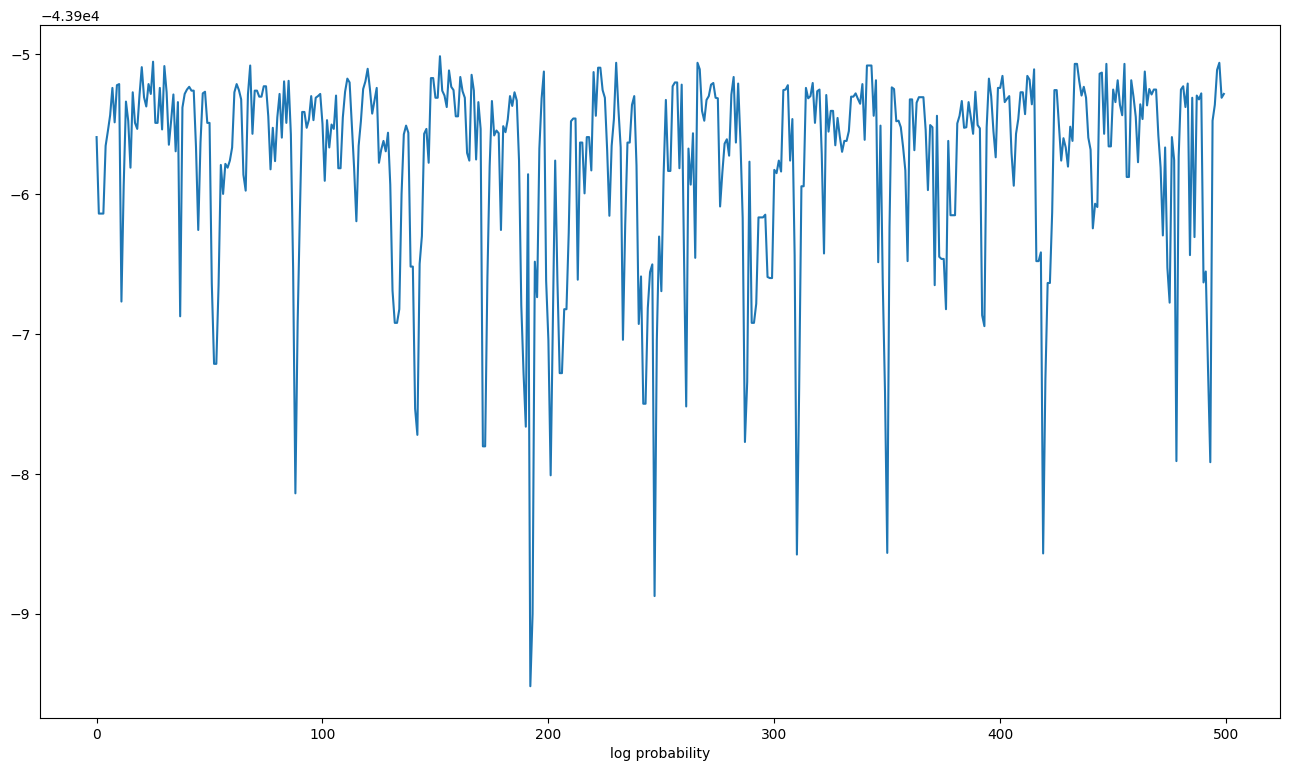

In [18]:
plt.plot(lps)
plt.xlabel("iteration")
plt.xlabel("log probability")

[(1, 29952, 1), (500, 29952, 1), (29952, 1), (29952, 1)]


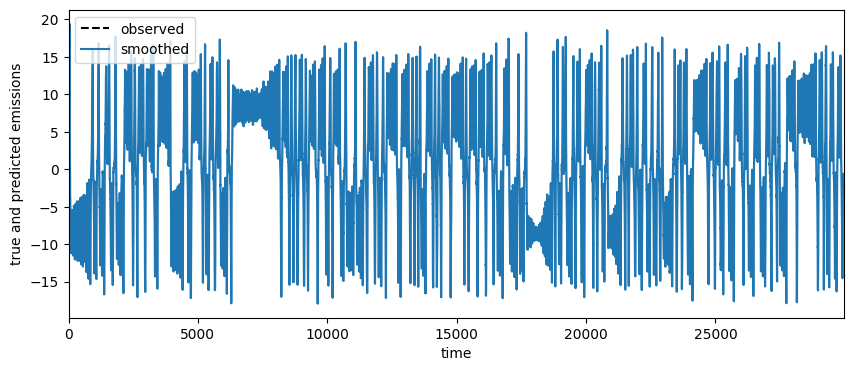

In [19]:
filtered_emissions = vmap(filter_emission)(param_samples)
filtered_emissions_mean = filtered_emissions.mean(axis=0)
filtered_emissions_std = jnp.std(filtered_emissions, axis=0)

# note that this shows a distribution of filtered means
# Unlike earlier plots, it does not show the filtered covariances, 
# which would add an appearance of greater uncertainty.
print([emissions.shape, filtered_emissions.shape, filtered_emissions_mean.shape, filtered_emissions_std.shape])
plot_results(emissions, filtered_emissions_mean, filtered_emissions_std)

## Plot the posterior distribution over sigma.

#### Notice that the posterior is centered around 9.97 and not 10 (the truth). Recall that this bias also appeared earlier in our plot of marginal log probablities---the bias comes from some combination of approximate-marginalization (via filtering) and finite data.

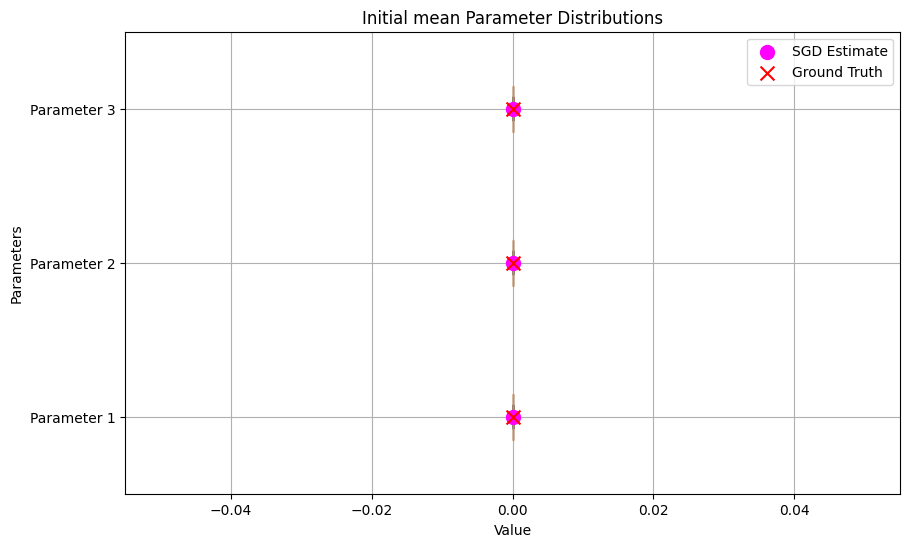

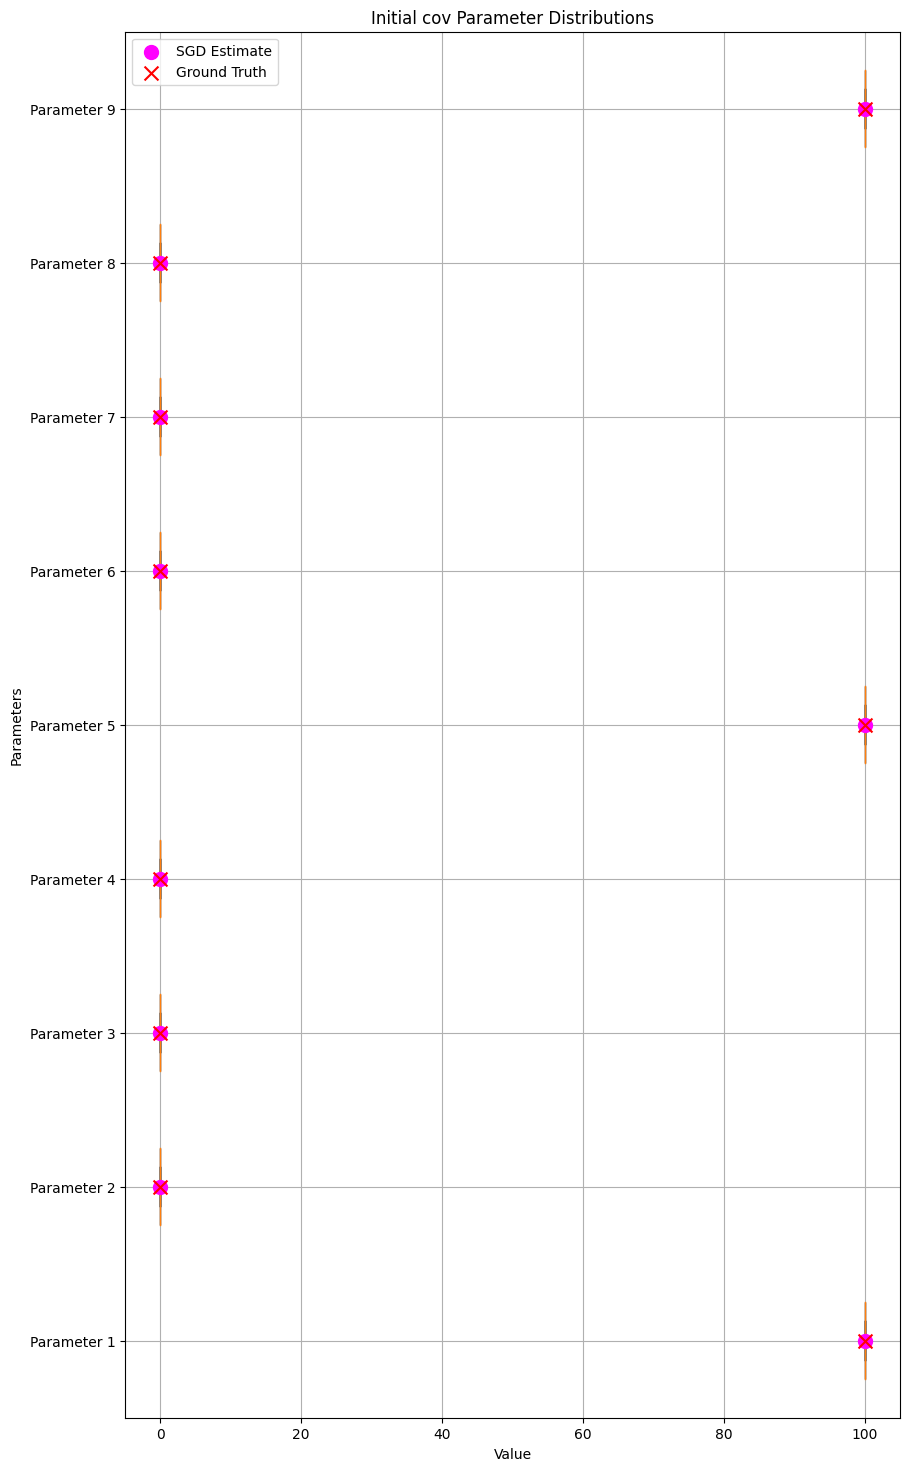

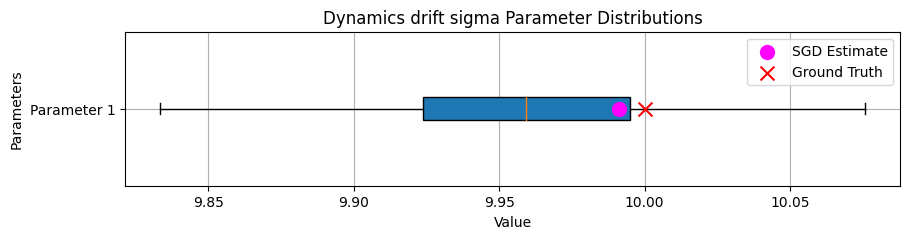

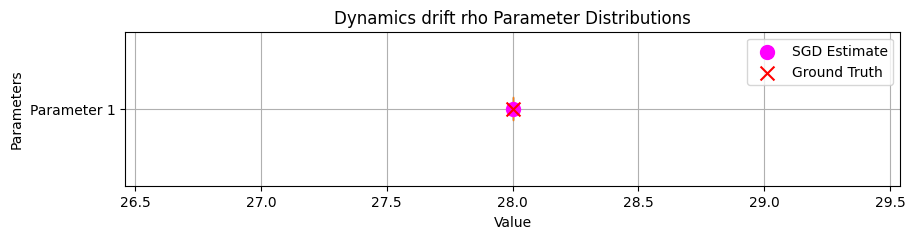

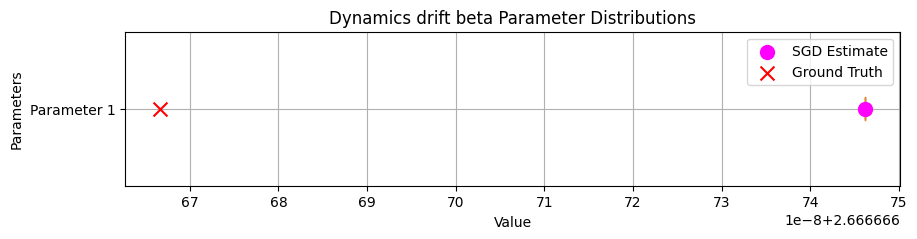

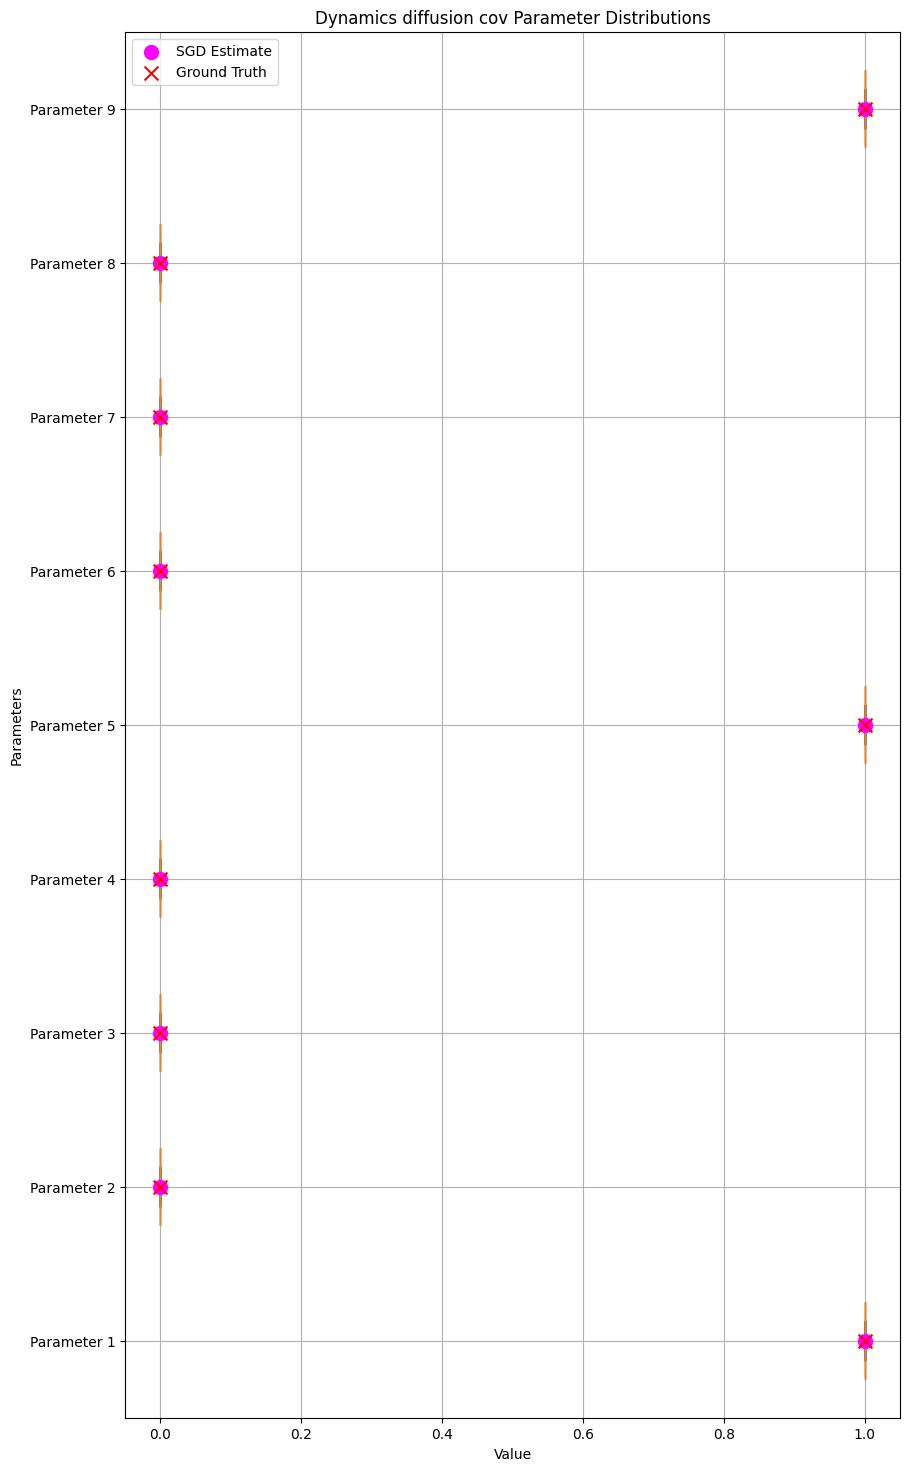

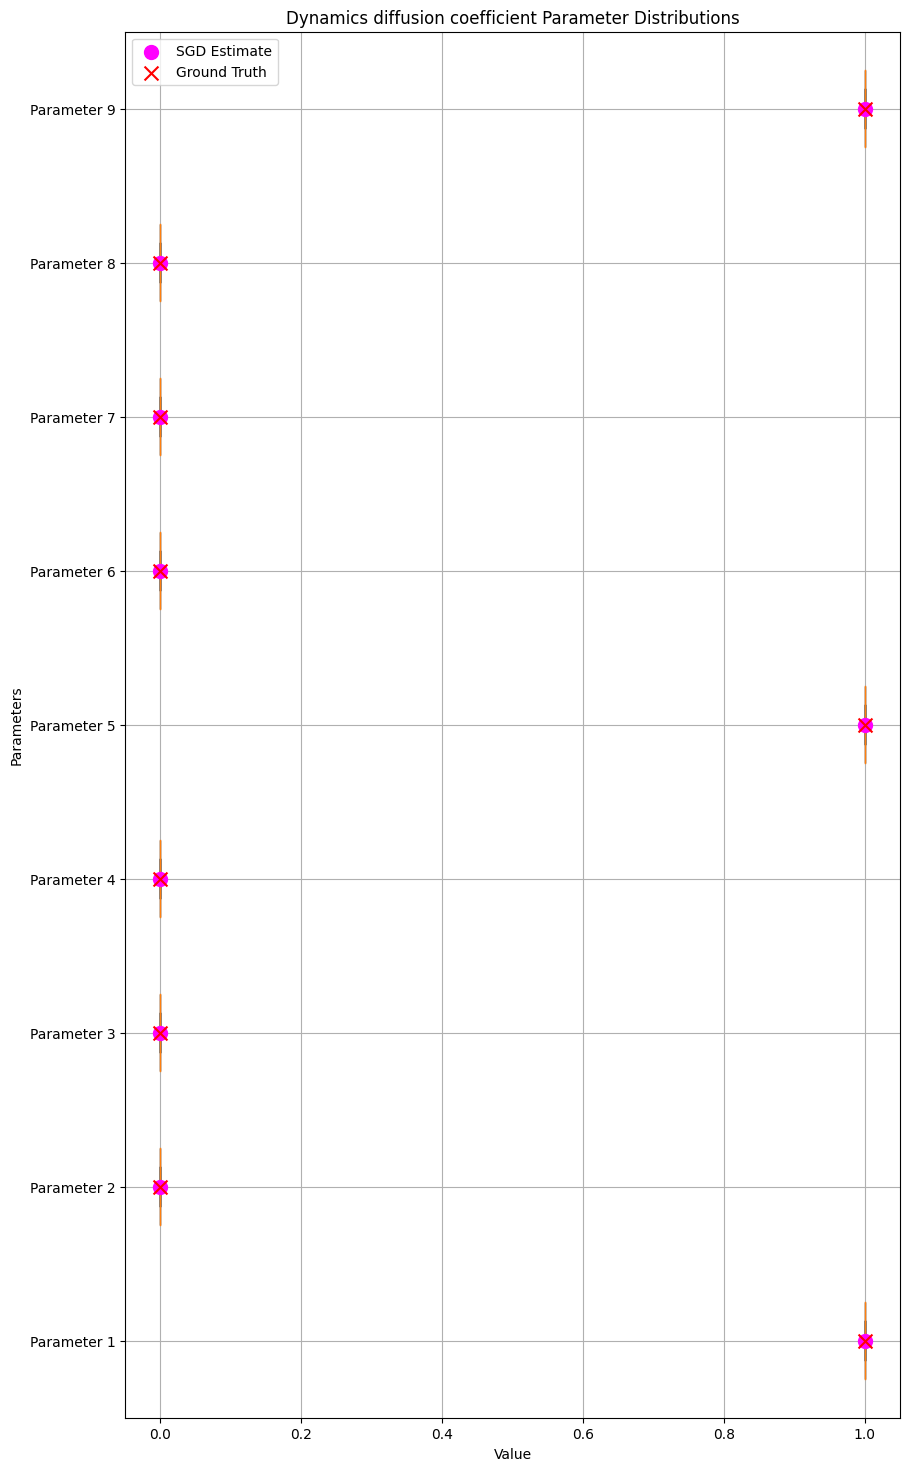

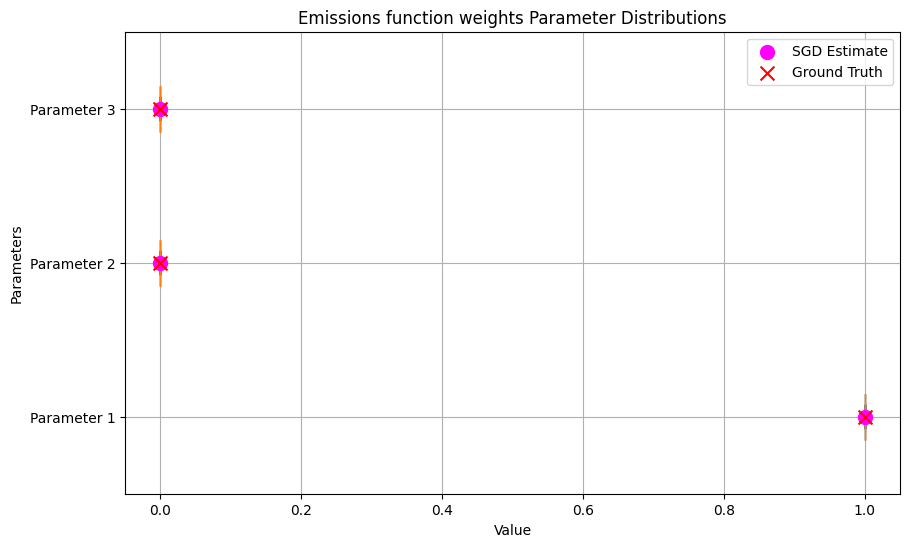

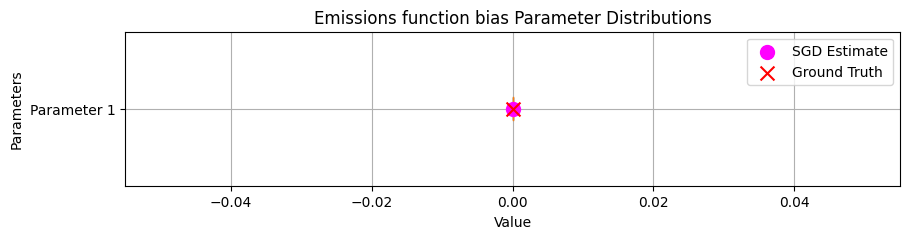

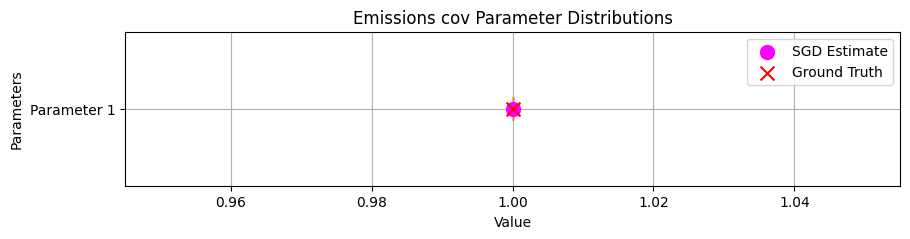

In [20]:
plot_all(param_samples)